# <center><u> Prediction Using K-Nearest Neighbors

###  Importing Required Packages 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem import SnowballStemmer

import re
from sklearn.manifold import TSNE
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

### Loading the Final Dataset

In [2]:
# os.getcwd()
conn = sqlite3.connect('finals_36k.sqlite')
final = pd.read_sql_query("""
SELECT *
FROM Reviews""",conn)
# preprocessed_reviews = final.CleanedText.values
final = final.drop(["level_0" , "index"] , axis = 1)
# print (type(preprocessed_reviews))
# print (len(preprocessed_reviews))

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
X = final
# X.shape = (X.shape[0] , 1)
Y = final.Score

In [5]:
print('Before UnderSampling, the shape of X: {}'.format(X.shape))
print('Before UnderSampling, the shape of Y: {} \n'.format(Y.shape))

print("Before UnderSampling, counts of label '1': {}".format(sum(Y == 1)))
print("Before UnderSampling, counts of label '0': {}".format(sum(Y == 0)))

Before UnderSampling, the shape of X: (363223, 12)
Before UnderSampling, the shape of Y: (363223,) 

Before UnderSampling, counts of label '1': 306226
Before UnderSampling, counts of label '0': 56997


### Undersampling the Data

In [6]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_new, Y_new = rus.fit_resample(X, Y)

print('After UnderSampling, the shape of X: {}'.format(X_new.shape))
print('After UnderSampling, the shape of Y: {} \n'.format(Y_new.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(Y_new == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(Y_new == 0)))

After UnderSampling, the shape of X: (113994, 12)
After UnderSampling, the shape of Y: (113994,) 

After UnderSampling, counts of label '1': 56997
After UnderSampling, counts of label '0': 56997


In [7]:
X_new = X_new.sort_values(by="Time")
X_new = X_new.drop(["Id" , "ProductId" , "UserId" , "ProfileName" , "HelpfulnessNumerator" , "HelpfulnessDenominator" , "Time" , "Summary" ] , axis = 1).reset_index(drop = True)
# pd.X_new.sort_values(by="Time")
X_new

Score                                               Text  \
0           0  I, myself always enjoyed this movie, it's very...   
1           1  This are so much easier to use than the Wilson...   
2           1  These are easy to use, they do not make a mess...   
3           1  This is such a great film, I don't even know h...   
4           0  Michael Keaton brings no distinguishing charac...   
...       ...                                                ...   
113989      0  For quite some time, I have been using differe...   
113990      1  Super give me full recovery after training in ...   
113991      0  I bought these to use as decorative center pie...   
113992      1  I was introduced to Lagavulin 16 three days ag...   
113993      0  Quite personally, I didn't like it.  For me, i...   

                                              CleanedText  \
0       i alway enjoy movi funni entertain i not hesit...   
1       this much easier use wilson past color color v...   
2       these easi use not make mess offer vibrant col...   
3       this great film i not even know sum first comp...   
4       michael keaton bring no distinguish characteri...   
...                                                   ...   
113989  for quit time i use differ type hot sauc diffe...   
113990  super give full recoveri train gym nice flavor...   
113991  i bought use decor center piec birthday parti ...   
113992  i introduc lagavulin three day ago i no singl ...   
113993  quit person i not like for no flavour it tast ...   

                                    Unstemmed_CleanedText  
0       i always enjoyed movie funny entertaining i no...  
1       this much easier use wilson paste colors color...  
2       these easy use not make mess offer vibrant col...  
3       this great film i not even know sum first comp...  
4       michael keaton brings no distinguishing charac...  
...                                                   ...  
113989  for quite time i using different types hot sau...  
113990  super give full recovery training gym nice fla...  
113991  i bought use decorative center pieces birthday...  
113992  i introduced lagavulin three days ago i no sin...  
113993  quite personally i not like for no flavour it ...  

[113994 rows x 4 columns]

In [8]:
Y_new = X_new.Score

In [9]:
sample_indices = np.sort(np.random.permutation(X_new.shape[0])[:60000])
# sample_indices = list(range(0,60000))
print(sample_indices)
X_new = X_new.take(sample_indices)
Y_new = Y_new.take(sample_indices)

print(X_new.shape , Y_new.shape)

[     0      1      2 ... 113986 113990 113992]
(60000, 4) (60000,)


In [10]:
from sklearn.model_selection import train_test_split

X_Train , X_Test , Y_Train , Y_Test = train_test_split(X_new , Y_new , test_size = 0.2 , shuffle = False)
x_train , x_cv , y_train , y_cv = train_test_split(X_Train , Y_Train , test_size = 0.2 , shuffle = False)

In [11]:
print("X shape :: " , X_Train.shape , "\nY shape :: " , Y_Train.shape)
print("=="*50)
print("X_Test shape :: " , X_Test.shape , "\nY_test shape :: " , Y_Test.shape)
print("=="*50)
print("x_train shape :: " , x_train.shape , "\ny_train shape :: " , y_train.shape)
print("=="*50)
print("x_cv shape :: " , x_cv.shape , "\ny_cv shape :: " , y_cv.shape)

X shape ::  (48000, 4) 
Y shape ::  (48000,)
X_Test shape ::  (12000, 4) 
Y_test shape ::  (12000,)
x_train shape ::  (38400, 4) 
y_train shape ::  (38400,)
x_cv shape ::  (9600, 4) 
y_cv shape ::  (9600,)


In [12]:
y_cv.value_counts()

0    5182
1    4418
Name: Score, dtype: int64

In [13]:
y_train.value_counts()

1    19855
0    18545
Name: Score, dtype: int64

In [14]:
Y_Test.value_counts()

0    6222
1    5778
Name: Score, dtype: int64

## Applying KNN 

#### <font color = 'darkblue'><i> Function to find the best 'K' and Visualize various Plots

In [18]:
from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [16]:
def KNN_find_k (train_data , train_target , cv_data = None , cv_target = None , upper_bound = 30 , algo = "brute" , metr = "cosine" 
                , plot_stuff = True):

    neigh = list(range(3,upper_bound,2))

    auc_train = []
    auc_cv = []
    f1 = []
    i = 0

    for k in tqdm(neigh):
        
        print("fitting...")
        KNN = KNeighborsClassifier(n_neighbors = k , algorithm = algo , metric = metr , n_jobs = -1)
        model = KNN.fit(train_data , train_target)
        print("fitted...")
        
        print("predicting...")
        train_pred = model.predict_proba(train_data)[: , 1]
        cv_pred = model.predict_proba(cv_data)[: , 1]
        print ("predicted...")
        
        auc_train.append(roc_auc_score(train_target, train_pred))
        auc_cv.append(roc_auc_score(cv_target,cv_pred))
        f1.append(f1_score(cv_target, model.predict(cv_data)))
        print("k =", k
              ,"-------> auc_train = " , auc_train[i]
              ,"-------> auc_cv = ",auc_cv[i]
              ,"------> f1_score = ", f1[i])
        i += 1

    print ("=="*50)

    idx_best_k, = np.where(f1 == max(f1))
    best_k = neigh[int(idx_best_k)]

    print ("BEST K ------> " , best_k)

    if (plot_stuff == True):
        auc_train = np.array(auc_train)
        auc_cv = np.array(auc_cv)
        plt.scatter(neigh, auc_train)
        plt.plot(neigh, auc_train, label="Train")
        plt.scatter(neigh, auc_cv)
        plt.plot(neigh, auc_cv, label='Cv')
        plt.scatter(neigh, auc_train-auc_cv)
        plt.plot(neigh, auc_train-auc_cv, label='Difference')
        plt.grid()
        plt.xlabel('K-hyperparameter')
        plt.ylabel('AUC')
        plt.legend()
        plt.title('AUC score V/S K')
        plt.show()
        
        plt.scatter(neigh, f1)
        plt.plot(neigh, f1)
        plt.title("K-hyperparameter V/S F1 Scores")
        plt.xlabel('K-hyperparameter')
        plt.ylabel('F1-Scores')
        plt.show()


    
    return best_k;

### [1] Applying KNN brute force on <font color='red'>BOW</font>

#### <u><font color = 'DarkOrange'> UNI-GRAM

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

cv = CountVectorizer(min_df = 10 , max_features = 5000)

bow_train = cv.fit(x_train.CleanedText)
bow_train = cv.transform(x_train.CleanedText)
bow_cv = cv.transform(x_cv.CleanedText)

bow_train = Normalizer().fit_transform(bow_train)
bow_cv = Normalizer().fit_transform(bow_cv)

In [18]:
bow_train.shape

(38400, 5000)

k = 3 -------> auc_train =  0.9377748904789149 -------> auc_cv =  0.735689246809916 ------> f1_score =  0.6847770374167094
k = 5 -------> auc_train =  0.9161325616742272 -------> auc_cv =  0.7767645216795744 ------> f1_score =  0.7028209053137984
k = 7 -------> auc_train =  0.904072733683721 -------> auc_cv =  0.7963588464160061 ------> f1_score =  0.7054545454545454
k = 9 -------> auc_train =  0.8961497132898069 -------> auc_cv =  0.8105987918832432 ------> f1_score =  0.7153774895785086
k = 11 -------> auc_train =  0.8911983208778622 -------> auc_cv =  0.8175100233188043 ------> f1_score =  0.7147379528666901
k = 13 -------> auc_train =  0.8873055368654109 -------> auc_cv =  0.8215301451670851 ------> f1_score =  0.7183081858144232
k = 15 -------> auc_train =  0.8845726905478823 -------> auc_cv =  0.825904906528343 ------> f1_score =  0.7198662047545096
k = 17 -------> auc_train =  0.8821154673558174 -------> auc_cv =  0.8292596040335121 ------> f1_score =  0.7211145808311313
k = 19 

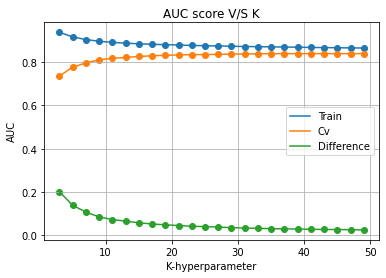

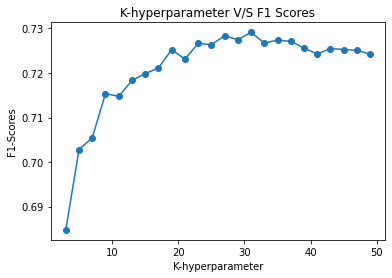

Using the best_k = 31
TEST roc_auc_score =  0.8489376913515153
TEST f1_score =  0.7281684698608965
TEST accuracy_score =  0.7655



AxesSubplot(0.125,0.125;0.62x0.755)


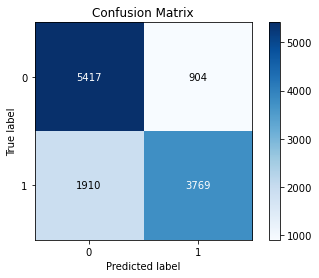

In [19]:
k = KNN_find_k (train_data = bow_train , train_target = y_train , cv_data = bow_cv , cv_target = y_cv , upper_bound = 50 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

cv = CountVectorizer(min_df = 10 , max_features = 5000)

bow_train = cv.fit(X_Train.CleanedText)
bow_train = cv.transform(X_Train.CleanedText)
bow_test = cv.transform(X_Test.CleanedText)

bow_train = Normalizer().fit_transform(bow_train)
bow_cv = Normalizer().fit_transform(bow_cv)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(bow_train , Y_Train)
y_pred_proba = KNN.predict_proba(bow_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

#### <u><font color = 'DarkOrange'> UNI+BI-GRAM

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

cv = CountVectorizer(ngram_range = (1,2) , max_features = 5000)

bow_train = cv.fit(x_train.CleanedText)
bow_train = cv.transform(x_train.CleanedText)
bow_cv = cv.transform(x_cv.CleanedText)

bow_train = Normalizer().fit_transform(bow_train)
bow_cv = Normalizer().fit_transform(bow_cv)

In [21]:
bow_train.shape

(38400, 5000)

k = 3 -------> auc_train =  0.9553502677360733 -------> auc_cv =  0.6881779967836403 ------> f1_score =  0.6367685919214798
k = 5 -------> auc_train =  0.9251895396683008 -------> auc_cv =  0.7686490673111915 ------> f1_score =  0.6989188198643943
k = 7 -------> auc_train =  0.913467710931671 -------> auc_cv =  0.7983489356509991 ------> f1_score =  0.7207027350768617
k = 9 -------> auc_train =  0.9056692268709473 -------> auc_cv =  0.815209892183033 ------> f1_score =  0.7314178638351032
k = 11 -------> auc_train =  0.9004556257591345 -------> auc_cv =  0.8252399629042262 ------> f1_score =  0.7348906986712388
k = 13 -------> auc_train =  0.8965636592688749 -------> auc_cv =  0.8312874297095963 ------> f1_score =  0.738760366652117
k = 15 -------> auc_train =  0.8935601533534744 -------> auc_cv =  0.8351023719505536 ------> f1_score =  0.738980792716776
k = 17 -------> auc_train =  0.8914488955036182 -------> auc_cv =  0.8395017810857266 ------> f1_score =  0.7418591549295773
k = 19 -

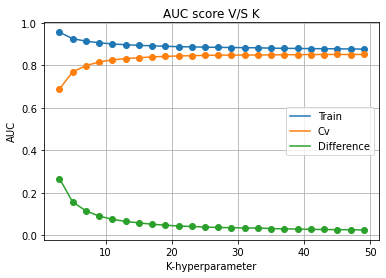

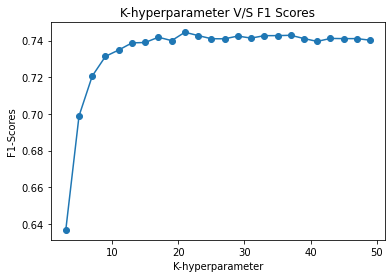

Using the best_k = 21
TEST roc_auc_score =  0.8582996542966216
TEST f1_score =  0.7651066088649031
TEST accuracy_score =  0.77875



AxesSubplot(0.125,0.125;0.62x0.755)


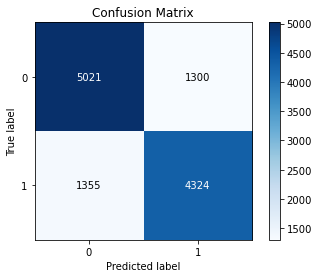

In [22]:
k = KNN_find_k (train_data = bow_train , train_target = y_train , cv_data = bow_cv , cv_target = y_cv , upper_bound = 50 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

cv = CountVectorizer(ngram_range = (1,2) , max_features = 5000)

bow_train = cv.fit(X_Train.CleanedText)
bow_train = cv.transform(X_Train.CleanedText)
bow_test = cv.transform(X_Test.CleanedText)

bow_train = Normalizer().fit_transform(bow_train)
bow_test = Normalizer().fit_transform(bow_test)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(bow_train , Y_Train)
y_pred_proba = KNN.predict_proba(bow_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

In [23]:
del bow_train , bow_cv , bow_test;

### [2] Applying KNN brute force on <font color='red'>TFIDF</font>

#### <u><font color = 'DarkOrange'> UNI-GRAM

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

cv = TfidfVectorizer(min_df = 10 , max_features = 5000)

tfidf_train = cv.fit(x_train.CleanedText)
tfidf_train = cv.transform(x_train.CleanedText)
tfidf_cv = cv.transform(x_cv.CleanedText)

bow_train = Normalizer().fit_transform(tfidf_train)
bow_cv = Normalizer().fit_transform(tfidf_cv)

In [25]:
bow_train.shape

(38400, 5000)

k = 3 -------> auc_train =  0.9345391675207917 -------> auc_cv =  0.6914394129529559 ------> f1_score =  0.6710235640648012
k = 5 -------> auc_train =  0.902474832239829 -------> auc_cv =  0.7358030461065017 ------> f1_score =  0.6845128005451183
k = 7 -------> auc_train =  0.8875122749191655 -------> auc_cv =  0.7564852379281518 ------> f1_score =  0.6902443870454997
k = 9 -------> auc_train =  0.8792965299762682 -------> auc_cv =  0.7720698418272811 ------> f1_score =  0.6981378963261198
k = 11 -------> auc_train =  0.8743608090030127 -------> auc_cv =  0.7816485611140899 ------> f1_score =  0.7028507659531298
k = 13 -------> auc_train =  0.8712370214006452 -------> auc_cv =  0.7882044319581812 ------> f1_score =  0.7074217951339195
k = 15 -------> auc_train =  0.8692578300510099 -------> auc_cv =  0.7944450385451416 ------> f1_score =  0.7144475337246422
k = 17 -------> auc_train =  0.8681251910788371 -------> auc_cv =  0.8006959587396264 ------> f1_score =  0.7182137688649989
k = 1

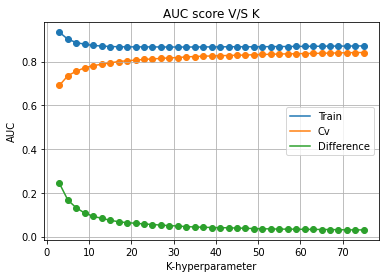

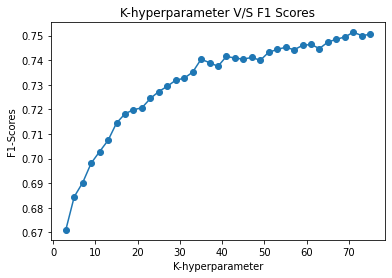

Using the best_k = 71
TEST roc_auc_score =  0.8662395887072217
TEST f1_score =  0.7818599311136624
TEST accuracy_score =  0.7783333333333333



AxesSubplot(0.125,0.125;0.62x0.755)


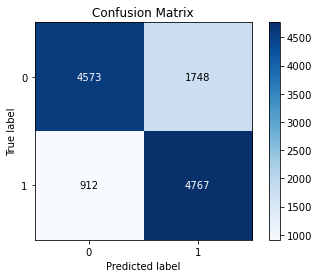

In [26]:
k = KNN_find_k (train_data = bow_train , train_target = y_train , cv_data = bow_cv , cv_target = y_cv , upper_bound = 76 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

cv = TfidfVectorizer(ngram_range = (1,2), max_features = 5000)

bow_train = cv.fit(X_Train.CleanedText)
bow_train = cv.transform(X_Train.CleanedText)
bow_test = cv.transform(X_Test.CleanedText)

bow_train = Normalizer().fit_transform(bow_train)
bow_test = Normalizer().fit_transform(bow_test)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(bow_train , Y_Train)
y_pred_proba = KNN.predict_proba(bow_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

In [27]:
del tfidf_train , tfidf_cv , bow_train , bow_test;

#### <u><font color = 'DarkOrange'> UNI+BI-GRAM

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

cv = TfidfVectorizer(ngram_range = (1,2), max_features = 5000)

tfidf_train = cv.fit(x_train.CleanedText)
tfidf_train = cv.transform(x_train.CleanedText)
tfidf_cv = cv.transform(x_cv.CleanedText)

bow_train = Normalizer().fit_transform(tfidf_train)
bow_cv = Normalizer().fit_transform(tfidf_cv)

In [29]:
bow_train.shape

(38400, 5000)

k = 3 -------> auc_train =  0.9723820905125587 -------> auc_cv =  0.6614572751597505 ------> f1_score =  0.6277903002981168
k = 5 -------> auc_train =  0.918916637571749 -------> auc_cv =  0.7400886996468158 ------> f1_score =  0.6810192582625515
k = 7 -------> auc_train =  0.9008835212198505 -------> auc_cv =  0.7672574076721266 ------> f1_score =  0.7003932785126923
k = 9 -------> auc_train =  0.8918355889322857 -------> auc_cv =  0.7859833353953265 ------> f1_score =  0.7128749423165667
k = 11 -------> auc_train =  0.8859686463563157 -------> auc_cv =  0.7985123145566387 ------> f1_score =  0.7175917215428034
k = 13 -------> auc_train =  0.8827307532977567 -------> auc_cv =  0.8043042573654126 ------> f1_score =  0.7237093690248566
k = 15 -------> auc_train =  0.8810035271764096 -------> auc_cv =  0.8102494184283452 ------> f1_score =  0.7285230024213073
k = 17 -------> auc_train =  0.8789563103755756 -------> auc_cv =  0.817922502067201 ------> f1_score =  0.7284119835519876
k = 19

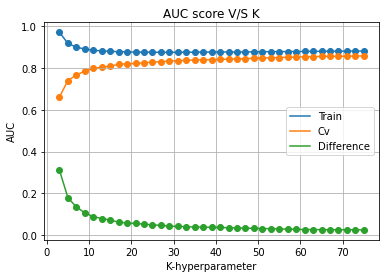

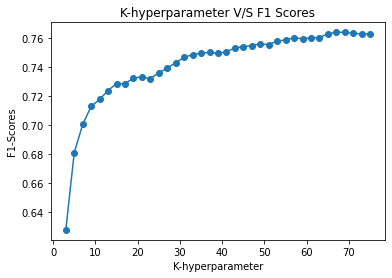

Using the best_k = 69
TEST roc_auc_score =  0.8657331251931397
TEST f1_score =  0.7811552642359689
TEST accuracy_score =  0.7774166666666666



AxesSubplot(0.125,0.125;0.62x0.755)


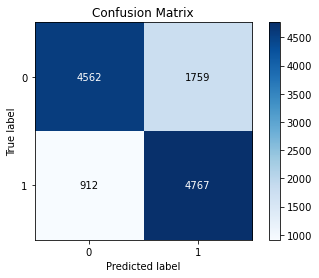

In [30]:
k = KNN_find_k (train_data = bow_train , train_target = y_train , cv_data = bow_cv , cv_target = y_cv , upper_bound = 76 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

cv = TfidfVectorizer(ngram_range = (1,2), max_features = 5000)

bow_train = cv.fit(X_Train.CleanedText)
bow_train = cv.transform(X_Train.CleanedText)
bow_test = cv.transform(X_Test.CleanedText)

bow_train = Normalizer().fit_transform(bow_train)
bow_test = Normalizer().fit_transform(bow_test)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(bow_train , Y_Train)
y_pred_proba = KNN.predict_proba(bow_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

In [35]:
del tfidf_train , tfidf_cv , bow_train , bow_test;

NameError: name 'tfidf_train' is not defined

In [32]:
# Please write all the code with proper documentation

### [3] Applying KNN brute force on <font color='red'>AVG W2V</font>

#### <font color = 'green'>Function to convert review text into Vectors using AVG-W2V

In [33]:
def convert_into_avg_w2v(w2v_new , x , vocabulary):
    avg_w2v = []
    
    for review in tqdm(x.Unstemmed_CleanedText):# preprocessed_reviews = 36k
        vec = np.zeros(150) # as we created 150 dimensional w2v
        count = 0
        for word in review.split():
            if word in vocabulary:
                vec += w2v_new[word]
                count += 1
        if count > 0:
            vec /= count
        
        avg_w2v.append(vec)
        
    avg_w2v = Normalizer().fit_transform(avg_w2v)
    
    return avg_w2v

#### <u> <font color = 'darkorange'>Using AVG-W2V

In [36]:
w2v_model = KeyedVectors.load_word2vec_format("w2v_own_model.bin" , binary = True)
vocabulary = w2v_model.key_to_index

avg_w2v_train = convert_into_avg_w2v(w2v_model ,x_train , vocabulary)

avg_w2v_cv = convert_into_avg_w2v(w2v_model ,x_cv , vocabulary)

print ("Shape of train :: " , avg_w2v_train.shape)
print ("Shape of CV :: " , avg_w2v_cv.shape)

100%|████████████████████████████████████████████████████████████████████████████| 9600/9600 [00:07<00:00, 1359.41it/s]

Shape of train ::  (38400, 150)
Shape of CV ::  (9600, 150)


k = 3 -------> auc_train =  0.9488480384426855 -------> auc_cv =  0.8177925986842896 ------> f1_score =  0.7415420023014961
k = 5 -------> auc_train =  0.9342428618986867 -------> auc_cv =  0.8454281504061354 ------> f1_score =  0.7531623534872925
k = 7 -------> auc_train =  0.9263170562256782 -------> auc_cv =  0.8590278437248975 ------> f1_score =  0.7658929196314008
k = 9 -------> auc_train =  0.9223484504249817 -------> auc_cv =  0.8660552780520182 ------> f1_score =  0.7708578143360753
k = 11 -------> auc_train =  0.9188239520117841 -------> auc_cv =  0.8712870739775402 ------> f1_score =  0.7691219799646435
k = 13 -------> auc_train =  0.9167639509021268 -------> auc_cv =  0.8747059693193775 ------> f1_score =  0.7724219210371244
k = 15 -------> auc_train =  0.9151596586618335 -------> auc_cv =  0.8777852803931198 ------> f1_score =  0.7725342142520057
k = 17 -------> auc_train =  0.9136563697945008 -------> auc_cv =  0.8795298751778169 ------> f1_score =  0.7725383062121393
k = 

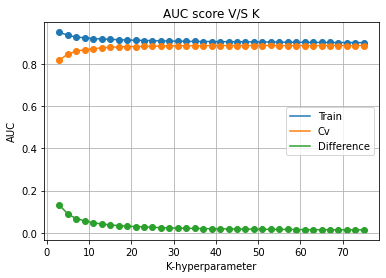

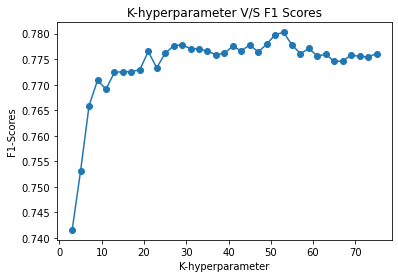

100%|██████████████████████████████████████████████████████████████████████████| 12000/12000 [00:10<00:00, 1199.57it/s]


Using the best_k = 53
TEST roc_auc_score =  0.8903337048689836
TEST f1_score =  0.7862389586238958
TEST accuracy_score =  0.8084166666666667



AxesSubplot(0.125,0.125;0.62x0.755)


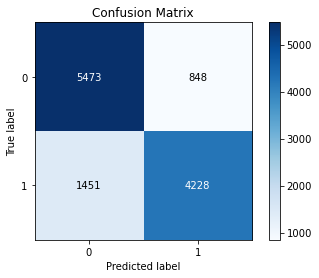

In [37]:
k = KNN_find_k (train_data = avg_w2v_train , train_target = y_train , cv_data = avg_w2v_cv , cv_target = y_cv , upper_bound = 76 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

avg_w2v_train = convert_into_avg_w2v(w2v_model , X_Train , vocabulary)
avg_w2v_test = convert_into_avg_w2v(w2v_model , X_Test , vocabulary)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(avg_w2v_train , Y_Train)
y_pred_proba = KNN.predict_proba(avg_w2v_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

In [38]:
# Please write all the code with proper documentation

del avg_w2v_train , avg_w2v_test , avg_w2v_cv;

### [4] Applying KNN brute force on <font color='red'>TFIDF W2V</font>

#### <font color = 'green'>Function to convert review text into Vectors using TF-IDF weighted W2V

In [39]:
def convert_into_tfidf_avg_w2v(w2v_new , x , vocabulary, tfidf , tfidf_feats):
    
    tfidf_w2v = []
    
    row = 0
    for review in tqdm(x.Unstemmed_CleanedText):
        review_vec = np.zeros(150)
        weighted_sum = 0

        for word in review.split():
            if word in vocabulary and word in tfidf_feats:

                vec = w2v_new[word]
                tfidf_val = tfidf[row , np.where(tfidf_feats == word)[0][0]]

                review_vec += (vec * tfidf_val)
                weighted_sum += tfidf_val

        if weighted_sum > 0:
            review_vec /= weighted_sum

        tfidf_w2v.append(review_vec)
        row += 1
        
    return Normalizer().fit_transform(tfidf_w2v)



#### <u><font color = 'DarkOrange'> UNI-GRAM

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

w2v_model = KeyedVectors.load_word2vec_format("w2v_own_model.bin" , binary = True)
vocabulary = w2v_model.key_to_index

cv = TfidfVectorizer(min_df = 10 , max_features = 5000)

tfidf_train = cv.fit(x_train.Unstemmed_CleanedText)
tfidf_train = cv.transform(x_train.Unstemmed_CleanedText)
tfidf_cv = cv.transform(x_cv.Unstemmed_CleanedText)

tfidf_train = Normalizer().fit_transform(tfidf_train)
tfidf_cv = Normalizer().fit_transform(tfidf_cv)

tfidf_feats = cv.get_feature_names_out()

tfidf_avg_w2v_train = convert_into_tfidf_avg_w2v(w2v_model , x_train , vocabulary, tfidf_train , tfidf_feats)
tfidf_avg_w2v_cv = convert_into_tfidf_avg_w2v(w2v_model , x_cv , vocabulary, tfidf_cv , tfidf_feats)

print ("Shape of tfidf_avg_w2v_train :: " , tfidf_avg_w2v_train.shape)
print ("Shape of tfidf_avg_w2v_cv :: " , tfidf_avg_w2v_cv.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 9600/9600 [01:26<00:00, 110.47it/s]

Shape of tfidf_avg_w2v_train ::  (38400, 150)
Shape of tfidf_avg_w2v_cv ::  (9600, 150)


k = 3 -------> auc_train =  0.9397730152079444 -------> auc_cv =  0.7888026211946121 ------> f1_score =  0.7058143567217663
k = 5 -------> auc_train =  0.9208941667167954 -------> auc_cv =  0.8160695488509047 ------> f1_score =  0.7230111996305277
k = 7 -------> auc_train =  0.9115619797903951 -------> auc_cv =  0.8271005639227125 ------> f1_score =  0.7289568137084635
k = 9 -------> auc_train =  0.9051114974789191 -------> auc_cv =  0.8347976179587177 ------> f1_score =  0.7351888208800093
k = 11 -------> auc_train =  0.9006011800175067 -------> auc_cv =  0.8425487091799104 ------> f1_score =  0.7395700174317257
k = 13 -------> auc_train =  0.8976986625369539 -------> auc_cv =  0.8451467986890007 ------> f1_score =  0.7398629022888347
k = 15 -------> auc_train =  0.8953800405906015 -------> auc_cv =  0.8492222250725459 ------> f1_score =  0.7443643969323728
k = 17 -------> auc_train =  0.8928803605649849 -------> auc_cv =  0.8510195896923535 ------> f1_score =  0.7453300846966006
k = 

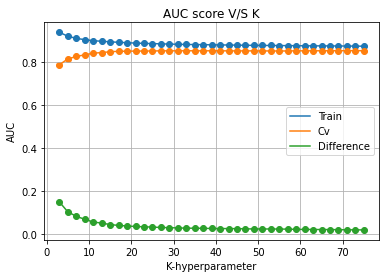

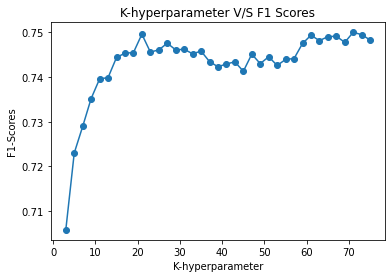

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:45<00:00, 113.63it/s]


Using the best_k = 71
TEST roc_auc_score =  0.8639921420641787
TEST f1_score =  0.7614795918367347
TEST accuracy_score =  0.7818333333333334



AxesSubplot(0.125,0.125;0.62x0.755)


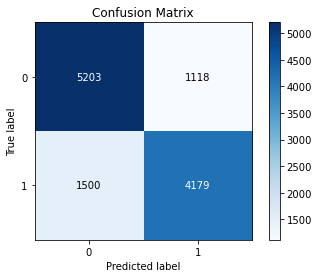

In [43]:
k = KNN_find_k (train_data = tfidf_avg_w2v_train , train_target = y_train , cv_data = tfidf_avg_w2v_cv , cv_target = y_cv , upper_bound = 76 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

cv = TfidfVectorizer(min_df = 10 , max_features = 5000)

tfidf_train = cv.fit(X_Train.Unstemmed_CleanedText)
tfidf_train = cv.transform(X_Train.Unstemmed_CleanedText)
tfidf_test = cv.transform(X_Test.Unstemmed_CleanedText)

tfidf_train = Normalizer().fit_transform(tfidf_train)
tfidf_test = Normalizer().fit_transform(tfidf_test)

tfidf_feats = cv.get_feature_names_out()

tfidf_avg_w2v_train = convert_into_tfidf_avg_w2v(w2v_model , X_Train , vocabulary , tfidf_train , tfidf_feats)
tfidf_avg_w2v_test = convert_into_tfidf_avg_w2v(w2v_model , X_Test , vocabulary , tfidf_test , tfidf_feats)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(tfidf_avg_w2v_train , Y_Train)
y_pred_proba = KNN.predict_proba(tfidf_avg_w2v_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

#### <u><font color = 'DarkOrange'> UNI+BI-GRAM

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

w2v_model = KeyedVectors.load_word2vec_format("w2v_own_model.bin" , binary = True)
vocabulary = w2v_model.key_to_index

cv = TfidfVectorizer(ngram_range = (1,2) , max_features = 5000)

tfidf_train = cv.fit(x_train.Unstemmed_CleanedText)
tfidf_train = cv.transform(x_train.Unstemmed_CleanedText)
tfidf_cv = cv.transform(x_cv.Unstemmed_CleanedText)

tfidf_train = Normalizer().fit_transform(tfidf_train)
tfidf_cv = Normalizer().fit_transform(tfidf_cv)

tfidf_feats = cv.get_feature_names_out()

tfidf_avg_w2v_train = convert_into_tfidf_avg_w2v(w2v_model , x_train , vocabulary, tfidf_train , tfidf_feats)
tfidf_avg_w2v_cv = convert_into_tfidf_avg_w2v(w2v_model , x_cv , vocabulary, tfidf_cv , tfidf_feats)

print ("Shape of tfidf_avg_w2v_train :: " , tfidf_avg_w2v_train.shape)
print ("Shape of tfidf_avg_w2v_cv :: " , tfidf_avg_w2v_cv.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 9600/9600 [01:32<00:00, 103.32it/s]

Shape of tfidf_avg_w2v_train ::  (38400, 150)
Shape of tfidf_avg_w2v_cv ::  (9600, 150)


k = 3 -------> auc_train =  0.9393717503289183 -------> auc_cv =  0.7897310206787393 ------> f1_score =  0.7066173068024063
k = 5 -------> auc_train =  0.920388075665856 -------> auc_cv =  0.816784050233212 ------> f1_score =  0.7212810396843815
k = 7 -------> auc_train =  0.9110206334344456 -------> auc_cv =  0.8259504437276682 ------> f1_score =  0.7272727272727273
k = 9 -------> auc_train =  0.9054030799412527 -------> auc_cv =  0.8349043594264254 ------> f1_score =  0.7353928034247368
k = 11 -------> auc_train =  0.900149708140232 -------> auc_cv =  0.8402770715700121 ------> f1_score =  0.7393276724438756
k = 13 -------> auc_train =  0.8968104667741 -------> auc_cv =  0.8448958196719915 ------> f1_score =  0.7405342624854819
k = 15 -------> auc_train =  0.8945257842207918 -------> auc_cv =  0.8480796215745111 ------> f1_score =  0.7451939881160433
k = 17 -------> auc_train =  0.892352685298575 -------> auc_cv =  0.8502793698438245 ------> f1_score =  0.745817843866171
k = 19 -----

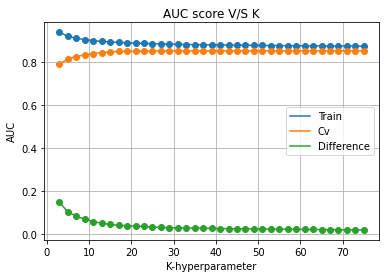

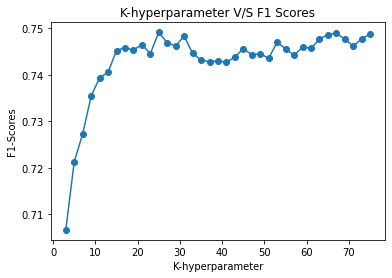

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:47<00:00, 112.11it/s]


Using the best_k = 25
TEST roc_auc_score =  0.861819701774738
TEST f1_score =  0.7612620828013861
TEST accuracy_score =  0.7818333333333334



AxesSubplot(0.125,0.125;0.62x0.755)


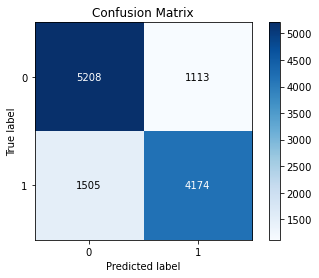

In [46]:
k = KNN_find_k (train_data = tfidf_avg_w2v_train , train_target = y_train , cv_data = tfidf_avg_w2v_cv , cv_target = y_cv , upper_bound = 76 , algo = "brute" , metr = "euclidean" 
                , plot_stuff = True)

cv = TfidfVectorizer(ngram_range = (1,2) , max_features = 5000)

tfidf_train = cv.fit(X_Train.Unstemmed_CleanedText)
tfidf_train = cv.transform(X_Train.Unstemmed_CleanedText)
tfidf_test = cv.transform(X_Test.Unstemmed_CleanedText)

tfidf_train = Normalizer().fit_transform(tfidf_train)
tfidf_test = Normalizer().fit_transform(tfidf_test)

tfidf_feats = cv.get_feature_names_out()

tfidf_avg_w2v_train = convert_into_tfidf_avg_w2v(w2v_model , X_Train , vocabulary , tfidf_train , tfidf_feats)
tfidf_avg_w2v_test = convert_into_tfidf_avg_w2v(w2v_model , X_Test , vocabulary , tfidf_test , tfidf_feats)

KNN = KNeighborsClassifier(n_neighbors = k , algorithm = 'brute')
model = KNN.fit(tfidf_avg_w2v_train , Y_Train)
y_pred_proba = KNN.predict_proba(tfidf_avg_w2v_test)[: , 1]

y_pred = []

for i in y_pred_proba:
    if (i > 0.5):
        y_pred.append(1)
    else:
        y_pred.append(0)

print("Using the best_k =" , k)
print("TEST roc_auc_score = " , roc_auc_score(Y_Test, y_pred_proba))
print("TEST f1_score = " , f1_score(Y_Test, y_pred))
print("TEST accuracy_score = " , accuracy_score(Y_Test, y_pred))

print("\n\n")
print(skplt.plot_confusion_matrix(Y_Test , y_pred))

## [5] Conclusions

The F1 Scores for various representations when KNN was used - 
1. BoW 
    - Uni-gram - 0.728 (k=31)
    - Uni+Bi-gram - 0.765 (k=21)
2. TF-IDF Weighted BoW
    - Uni-gram - 0.781 (k=71)
    - Uni+Bi-gram - 0.781 (k=69)
3. Word2Vec
    - Uni-gram Average Word2Vec - 0.786 (k=53)
    - TF-IDF Weighted Average Word2Vec
      - Uni-gram - 0.761 (k=71)
      - Uni+Bi-gram - 0.761 (k=25)